In [1]:
# 작업 환경 설정
import matplotlib.dates as md
import pandas as pd
import numpy as np
import math
import datetime

import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from matplotlib import rc

plt.style.use('seaborn')
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
%matplotlib inline

# Regression Project

## 주제 :  

제주도내 전력 수요 예측

## 배경 : 

1. 전력수요 예측은 전력 공급정책의 기초자료중 하나. 
전력수요 예측은 에너지 분야 최상위 행정계획인 에너지기본계획에 영향을 미침.

관련기사 \
http://www.headlinejeju.co.kr/news/articleView.html?idxno=417262 \
"제주도 6차 지역에너지계획, 전력설비, 풍력발전 공급과잉" - 2020년 5월 기사 

2. 제주도 전력수요 예측의 실패 현황

관련 기사 \
http://www.jejusori.net/news/articleView.html?idxno=132579 \
"올 여름 제주지역 최대 전력수요 예측량도 빗나갔다" -2013년 기사 \
http://www.jejusori.net/news/articleView.html?idxno=209324 \
"제주 최대 전력수요 빗나가.. 10% 증가 법칙도 깨져"
"101만 5000kW 까지 치솟을 것으로 전망했지만, 6만 6000kW를 밑돌아" - 2018년 8월 기사 


3. 제주도 관광객 유입에 따른 전력수요 증가

관련기사 \
http://www.headlinejeju.co.kr/news/articleView.html?idxno=369648 \
"여름 휴가시즌을 맞아 제주관광이 최성수기를 맞아 전력이 풀가동.." - 2019년 8월 기사 


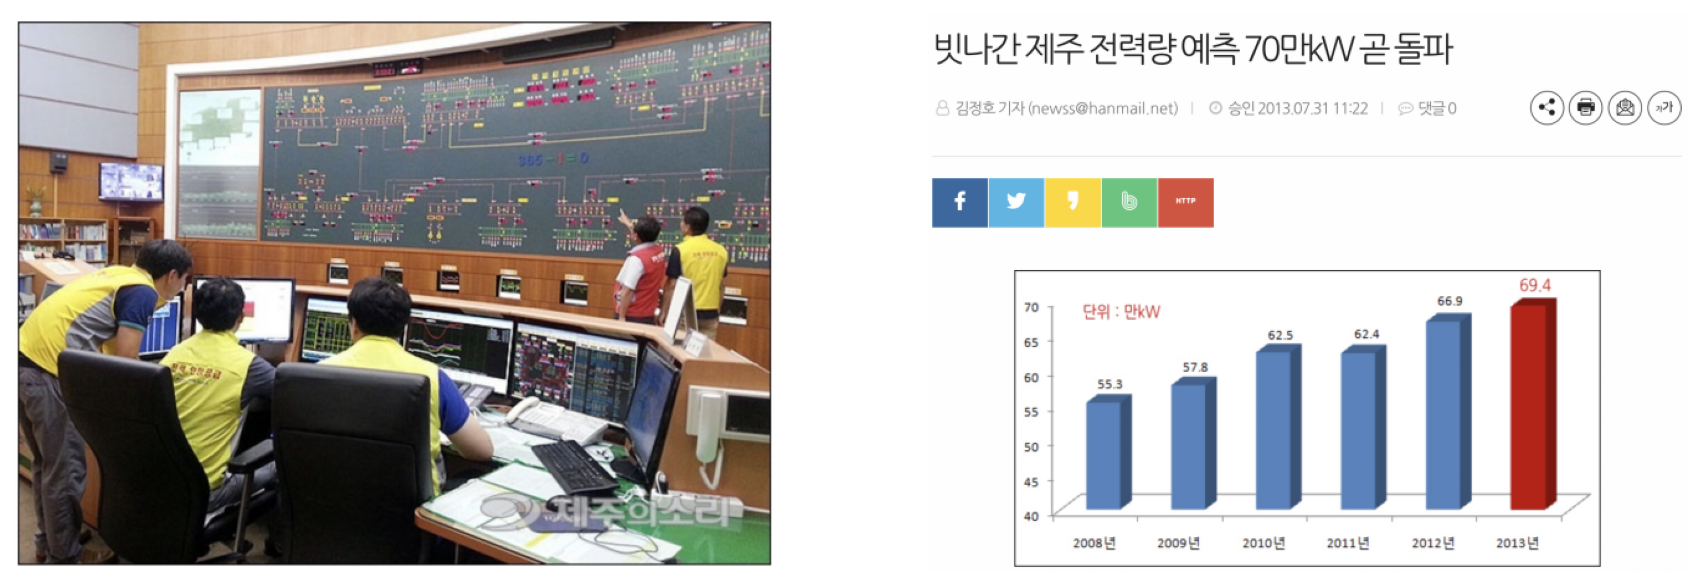

In [3]:
img1 = mpimg.imread('policies.png')
img2 = mpimg.imread('false_prediction.png')

plt.figure(figsize =(15, 10))

plt.subplot(121)
plt.imshow(img1)
plt.grid(False)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(img2)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

## 문제 정의 : 

기상데이터만을 활용한 전력수요 예측은 한계가 있어 전력 공급과잉 또는 공급부족에 영향을 끼칠수 있다. 
1. 이에 기상변수가 아닌, 일일 내외국인 관광객수와 불쾌지수, 체감온도를 추가 변수로 선정하여 전력수요 예측의 정확성을 향상.
2. 여름, 겨울, 환절기의 계절 특수성을 고려, 해당 기간에 따라 다른 독립변수를 사용
3. 기존 다중선형회귀분석 이외, 공휴일, 주말 같은 특수일에 대한 전력 수요 예측 시 퍼지 선형회귀모델 사용
4. 체감온도, 불쾌지수는 온도에서 파생되어 다중공선성 발생, 이를 제거하기 위한 방법론 사용(PCA, 상호작용)

## 참고 문헌:

#### 1. 변수추가 관련 문헌

(1) 논문1

- 관광객수를 전력량 예측에 독립변수로 사용할수 있는 유사한 사례 찾음(지역 산업 변수)

    - 다중회귀분석법을 이용 지역 전력수요 예측 알고리즘/ 전기 설비학회/ 남봉우,송경빈,김규호,차준민 / 2008.02

(2) 논문2

- 다중회귀 분석에서 기온 강수량 계절 같은 기상 변수 뿐만 아니라 사회적 경제 변수를 넣어 분석

    - 기상변수 이용한 도서지역 전력수요 예측 모형의 적합성에 관한 연구/ 한국신재생에너지학회/ 김영은/2017.12.07


#### 2. 방법론 관련 문헌

(1) 논문1

- 퍼지최소자승을 이용한 특수일(공휴일) 전력 예측

    - 퍼지최소자승 선형회귀분석 알고리즘을 이용 특수일 전력수요 예측/대한 전기학회/구본식 백영식 송중빈/2001.11.16

(2) 보고서1
- 기상 데이터는 매 시간의 데이터가 있는데 용도별 데이터(관광객은) 월간 일간 주간 등으로 주기가 다를때 가중치를 두어서 데이터 쪼개 기상데이터와 다중회귀모형을 돌릴수 있다.(MIDAS모형)

    - 혼합주기 자료를 이용한 전력수요 예측 모형구축/에너지경제연구원/ 김철현/박명덕/14.06

(3) 논문2

- 삼층 계절법이 이중 계절법 보다 뛰어나라는 타 논문 인용과 추운날/여름날 기상 변수에 대한 상관성이 높다.
- 모든 계절에 대하여 최대기온/최저기온/체감온도/불쾌지수가 상관성이 높다.

    - 전력수요 예측을 위한 기상 정보 활용성 평가 / 한국 데이터 정보 과학지/ 신이레,윤상후 /2016.2.16


#### 3. 다중공선성 관련 문헌

(1) 논문1

- 독립 변수간의 다중공선성이 존재할 경우의 방법론1

    - 상호작용을 고려한 다중회귀분석을 이용한 미래 최심신적설 빈도 분석/ 한국방재학회/박희성,정상만,정건희/2016.1

(2) 논문2

- 다중공선성 제거 방법론
    - 주성분 회귀모형의 베이지안 분석 / 한국데이터 정보 과학회지/경민정 / 2019년

## 데이터 
1. 기상/전력 데이터 https://dacon.io/competitions/official/235606/overview/ (데이콘)

2. 관광객 데이터 http://www.visitjeju.or.kr/web/bbs/bbsList.do?bbsId=TOURSTAT (제주도 관광협회)

3. 제주도 인구 데이터 https://www.jeju.go.kr/open/stats/news/trend.htm?act=view&seq=1162310&page=9 (제주도청)

수집 기간 : 2018.02.01 ~ 2020.05.18

## 변수 :

1. 독립변수 
    - 온도 (temp, celcius)
    - 체감온도 (body_temp, celcius)
    - 풍속 (ws, m/s)
    - 습도 (humid, %)
    - 불쾌지수 (angry, d.index) 
    - 관광객 (tour, 명)
    - 강수량 (prec, mm)
    - 가격(smp, 원/kWh)
    - 인구수(추가예정)
   

2. 종속변수 
    - 전력공급량 (supply, 만kW)

## 전처리

#### 날씨 데이터 불러오기
- ASOS 관측소의 데이터만 사용
- 전국적으로 ASOS가 관측한 기온이 공식으로 인정받고, AWS상의 기온은 참고용으로 사용
    - 참고자료: https://www.yna.co.kr/view/AKR20180723154300004

- area: 184(제주), 185(고산), 188(성산), 189(서귀포)

In [4]:
weather_df = pd.read_csv("weather_v2.csv")
weather_df = weather_df[weather_df["station"] == "ASOS"]

C:\Users\tjsgm\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### datetime 컬럼을 date와 time으로 나누기

In [5]:
def split_date(data, col):
    date = data[col].str.split(' ').str[0]
    time = data[col].str.split(' ').str[1]
    return date, time

In [6]:
weather_df["date"], weather_df["time"] = split_date(weather_df, "datetime")

##### 날씨 데이터의 36개의 독립변수 중 사용할 독립변수만 추출
- 온도, 풍속, 강수량, 습도(상대) 사용

In [7]:
weather_useful = weather_df[["date", "time", "temp", "ws", "prec", "humid"]]

In [8]:
# 각 독립변수들의 Null값 확인
weather_useful.isnull().sum().sort_values()

date         0
time         0
humid       43
temp        45
ws         505
prec     71820
dtype: int64

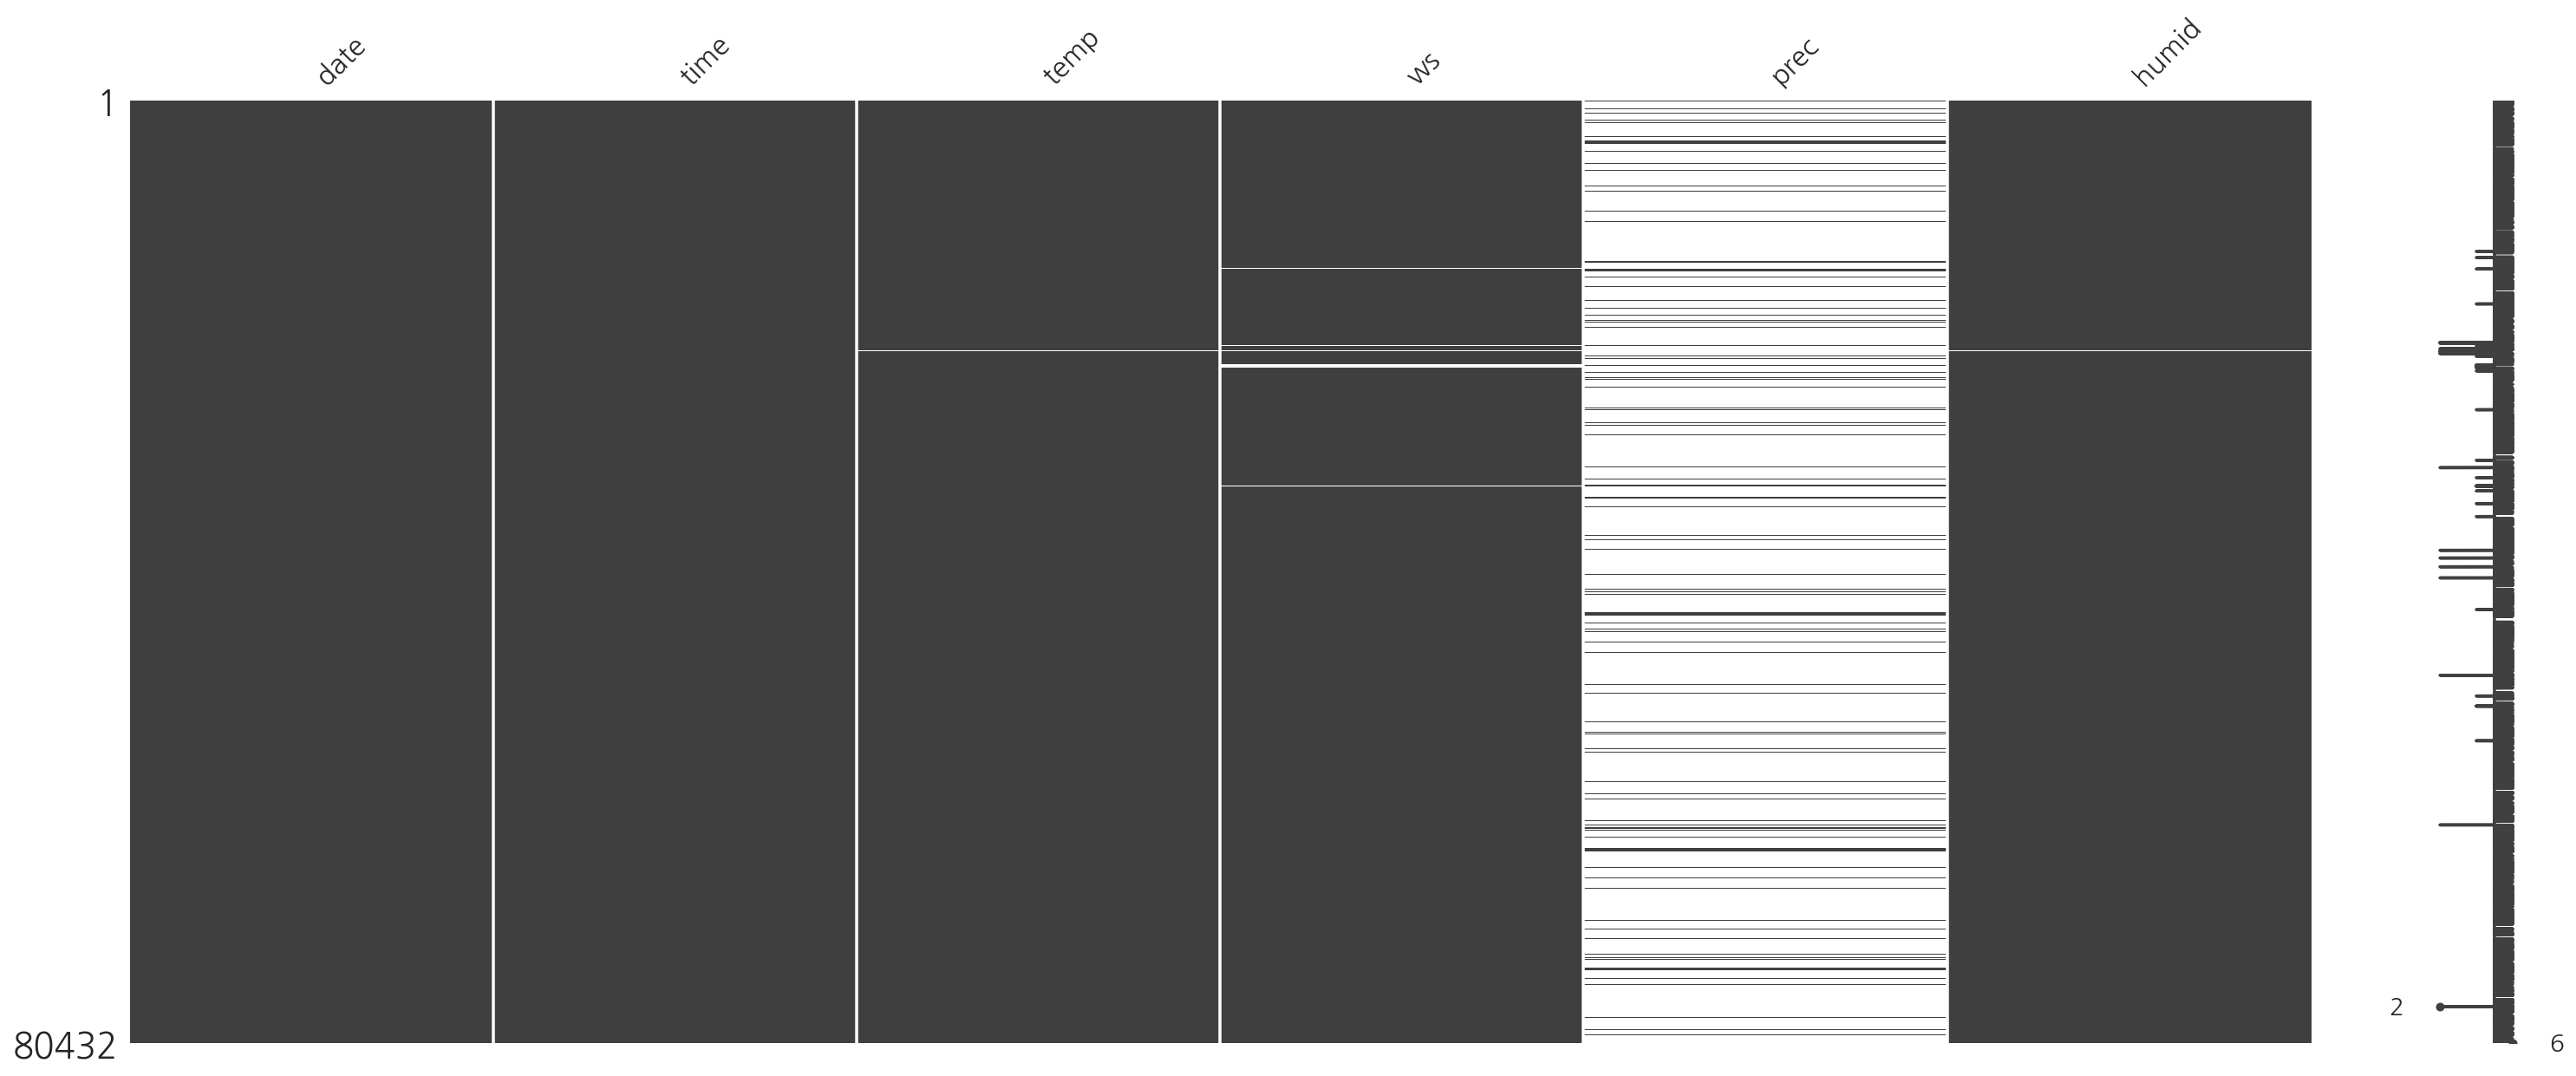

In [9]:
msno.matrix(weather_useful)
plt.show()

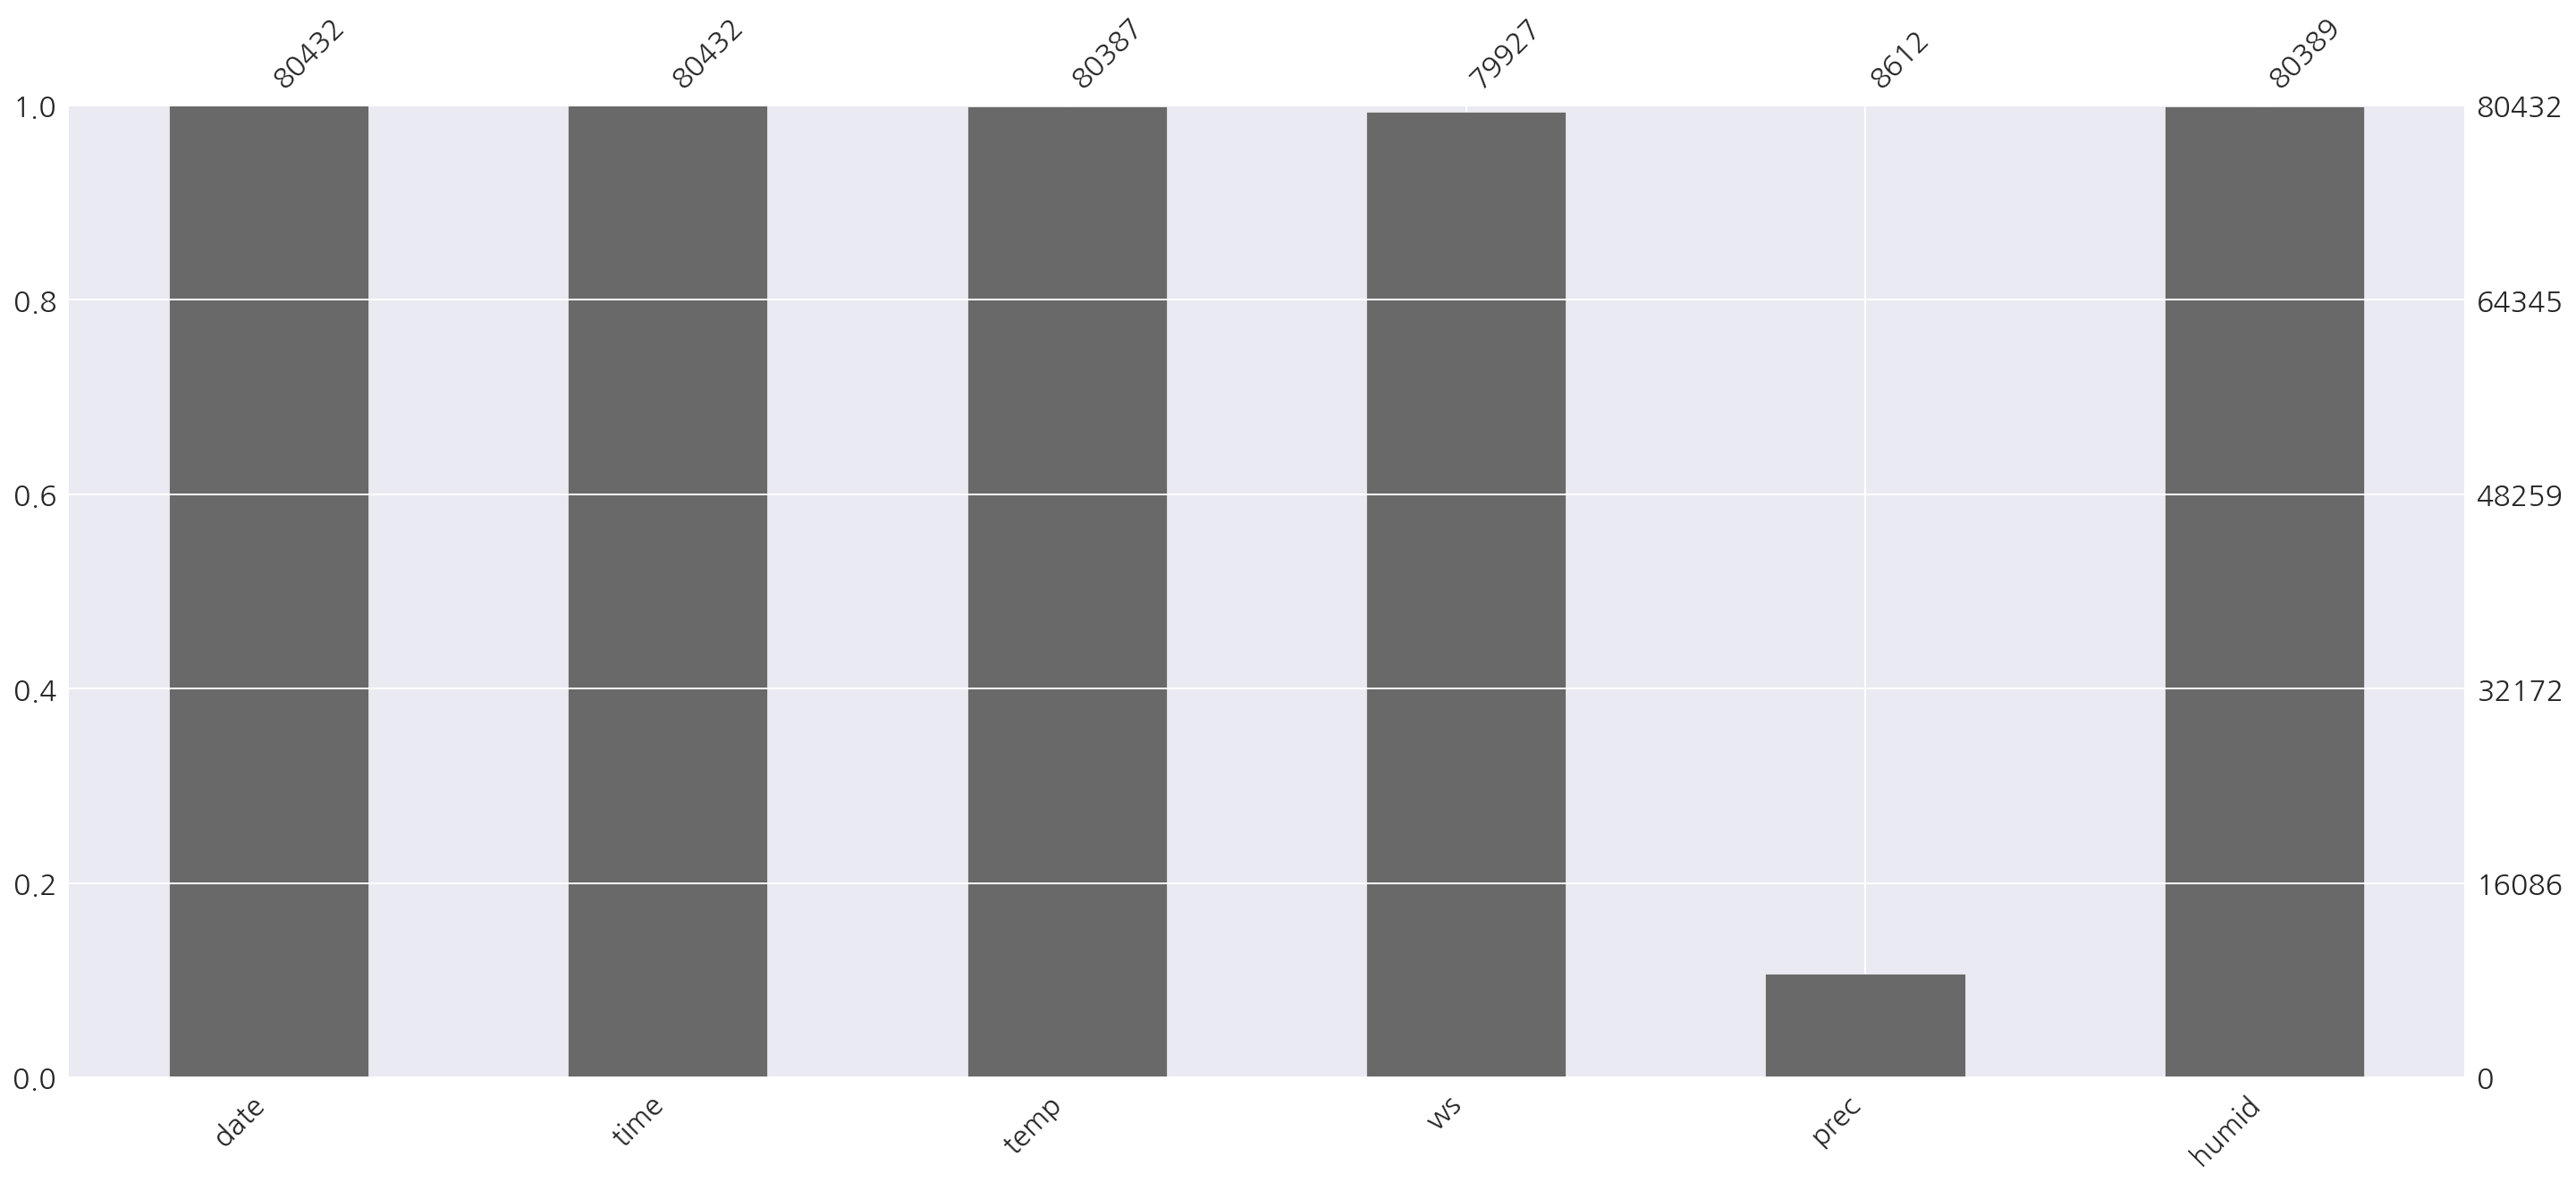

In [10]:
msno.bar(weather_useful)

##### 결측값을 채운후 결측값 확인
- 제주도 지하수정보 관리시스템에서 강수 정보 확인 결과 결측데이터를 0으로 처리하기로 함

In [11]:
#weather_full=weather_useful.fillna(method="bfill") - 0.793 
#weather_full = weather_useful.fillna(method = "pad") #- 0.796
weather_useful["prec"] = weather_useful["prec"].fillna(0)
weather_full = weather_useful.interpolate(method='values')  #0.908

C:\Users\tjsgm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
weather_full.isnull().sum()

date     0
time     0
temp     0
ws       0
prec     0
humid    0
dtype: int64

In [13]:
# date의 자료형을 datetime으로 변환
weather_full['date'] = pd.to_datetime(weather_full['date'])

In [14]:
weather_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80432 entries, 0 to 80431
Data columns (total 6 columns):
date     80432 non-null datetime64[ns]
time     80432 non-null object
temp     80432 non-null float64
ws       80432 non-null float64
prec     80432 non-null float64
humid    80432 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 4.3+ MB


##### 체감온도 및 불쾌지수 추가
- 불쾌지수
    - 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3
    
- 체감온도
    - 기상자료개방포털 자료 활용 (각 관측소 184(제주), 185(고산), 188(성산), 189(서귀포)에서 측정된 일간 체감온도)
        
- 자료 출처 : 체감온도 - 기상청, 불쾌지수 - 위키백과

In [15]:
# 불쾌지수 연산 함수
def discomfort_index(temp, rh):
    discomfort = round(0.81 * temp + 0.01 * rh * (0.99 * temp - 14.3) + 46.3, 1)
    return discomfort

In [16]:
# 불쾌지수 추가
weather_full["angry"] = discomfort_index(weather_full["temp"], weather_full["humid"])

In [17]:
# 시간별, 관측소별로 나눠진 데이터들을 일일 평균으로 하나의 데이터로 합침
weather_full = weather_full.groupby("date").mean().reset_index()

In [18]:
# 각 독립변수들의 값을 소수점 둘째자리에서 반올림
weather_full[["temp", "ws", "prec", "humid", "angry"]]= weather_full[["temp", "ws", "prec", "humid", "angry"]].round(1)

In [19]:
weather_full.tail()

,date,temp,ws,prec,humid,angry
833,2020-05-14,18.7,2.7,0.0,56.3,63.7
834,2020-05-15,19.9,3.5,1.5,91.5,67.3
835,2020-05-16,17.6,2.0,0.2,96.6,63.5
836,2020-05-17,17.1,2.2,0.0,91.6,62.4
837,2020-05-18,19.2,3.1,0.4,92.1,66.2


In [20]:
# 체감온도 추가
body_temp = pd.read_csv("body_temp.csv")
body_temp = body_temp.drop("Unnamed: 0", axis = 1)

In [21]:
body_temp.tail()

,date,temp,ws,body_temp,area
3347,2020-05-14,19.1,0.8,19.1,189
3348,2020-05-15,19.8,1.4,19.8,189
3349,2020-05-16,18.4,0.9,18.4,189
3350,2020-05-17,17.6,1.0,17.6,189
3351,2020-05-18,19.6,0.9,19.6,189


In [22]:
# 4개의 관측소의 평균 일별 체감온도 컬럼 추가
weather_full["body_temp"] = body_temp.groupby("date").mean().reset_index()["body_temp"].round(1)

In [23]:
weather_full.tail()

,date,temp,ws,prec,humid,angry,body_temp
833,2020-05-14,18.7,2.7,0.0,56.3,63.7,18.6
834,2020-05-15,19.9,3.5,1.5,91.5,67.3,19.8
835,2020-05-16,17.6,2.0,0.2,96.6,63.5,17.4
836,2020-05-17,17.1,2.2,0.0,91.6,62.4,17.0
837,2020-05-18,19.2,3.1,0.4,92.1,66.2,19.1


##### 상대습도(humid) 변환
- humid : % -> /100

In [24]:
weather_full["humid"] = weather_full["humid"] / 100

In [25]:
weather_full.tail()

,date,temp,ws,prec,humid,angry,body_temp
833,2020-05-14,18.7,2.7,0.0,0.563,63.7,18.6
834,2020-05-15,19.9,3.5,1.5,0.915,67.3,19.8
835,2020-05-16,17.6,2.0,0.2,0.966,63.5,17.4
836,2020-05-17,17.1,2.2,0.0,0.916,62.4,17.0
837,2020-05-18,19.2,3.1,0.4,0.921,66.2,19.1


In [26]:
weather_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 7 columns):
date         838 non-null datetime64[ns]
temp         838 non-null float64
ws           838 non-null float64
prec         838 non-null float64
humid        838 non-null float64
angry        838 non-null float64
body_temp    838 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 46.0 KB


##### 관광객 데이터 불러오기
- datetime의 데이터 타입을 datetime형태로 형변환
- tour에서 ' , ' 를 제외하고 int형태로 형변환

In [27]:
tour_df = pd.read_csv("tour_stat.csv")
tour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 2 columns):
date    838 non-null object
tour    838 non-null int64
dtypes: int64(1), object(1)
memory usage: 13.2+ KB


In [28]:
tour_df["date"]= pd.to_datetime(tour_df["date"])
tour_df["tour"] =  tour_df["tour"].astype(int)
tour_df.tail()

,date,tour
833,2020-05-14,23327
834,2020-05-15,22135
835,2020-05-16,23009
836,2020-05-17,24394
837,2020-05-18,24001


##### target 데이터 불러오기
- 일별 최대 smp, 최소 smp, 평균 smp, 전력 수요량

In [29]:
# target 데이터 불러오기
target = pd.read_csv("target_v2.csv")
# target의 날짜 데이터의 자료형을 str -> datetime으로 변환
target['date'] = pd.to_datetime(target['date'])

In [30]:
# target 데이터프레임의 결측값 확인
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 5 columns):
date        838 non-null datetime64[ns]
smp_max     838 non-null float64
smp_min     838 non-null float64
smp_mean    838 non-null float64
supply      838 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 32.9 KB


##### 날짜를 기준으로 날씨, 관광객, 타겟 데이터프레임 병합

In [31]:
# 날씨 데이터와 병합
target_v2 = target.merge(weather_full)
target_v2 = target_v2.merge(tour_df)

In [32]:
# 컬럼 재정렬
target_v2 = target_v2[["date", "smp_max", "smp_min", "smp_mean", "temp", "ws", "prec", "humid", "angry", "body_temp", "tour", "supply"]]
target_v2.tail()

,date,smp_max,smp_min,smp_mean,temp,ws,prec,humid,angry,body_temp,tour,supply
833,2020-05-14,193.28,66.78,100.46,18.7,2.7,0.0,0.563,63.7,18.6,23327,62.70
834,2020-05-15,198.23,61.81,102.38,19.9,3.5,1.5,0.915,67.3,19.8,22135,64.91
835,2020-05-16,220.91,88.50,121.19,17.6,2.0,0.2,0.966,63.5,17.4,23009,61.75
836,2020-05-17,207.75,65.78,116.82,17.1,2.2,0.0,0.916,62.4,17.0,24394,61.55
837,2020-05-18,113.31,66.86,98.98,19.2,3.1,0.4,0.921,66.2,19.1,24001,63.91


In [74]:
ls

Index(['temp', 'ws', 'prec', 'humid', 'angry', 'body_temp', 'tour', 'supply'], dtype='object')

TypeError: unsupported operand type(s) for /: 'str' and 'int'

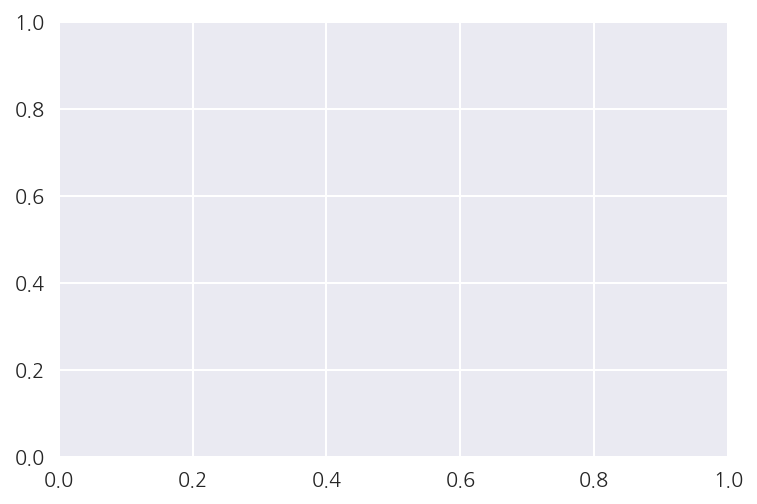

In [73]:
plt.boxplot([target_v2["temp"], target_v2["ws"], target_v2["prec"], target_v2["humid"], target_v2["angry"], target_v2["body_temp"]])
plt.show()

## OLS 분석
##### 전체 기간에 대한 각 독립변수간의 상관관계 OLS

In [33]:
formula = ("supply ~ scale(smp_max) + scale(smp_min) + scale(smp_mean) +\
                            scale(temp) + scale(ws) + scale(prec) + scale(humid) + \
                            scale(angry) + scale(body_temp) + scale(tour)")

In [34]:
model1 = sm.OLS.from_formula(formula, data=target_v2)

In [35]:
result1 = model1.fit()

In [36]:
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                 supply   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     123.2
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          2.47e-156
Time:                        16:42:52   Log-Likelihood:                -2627.3
No. Observations:                 838   AIC:                             5277.
Df Residuals:                     827   BIC:                             5329.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           74.2255      0.193  

#### 독립변수 간 다중공선성 발견

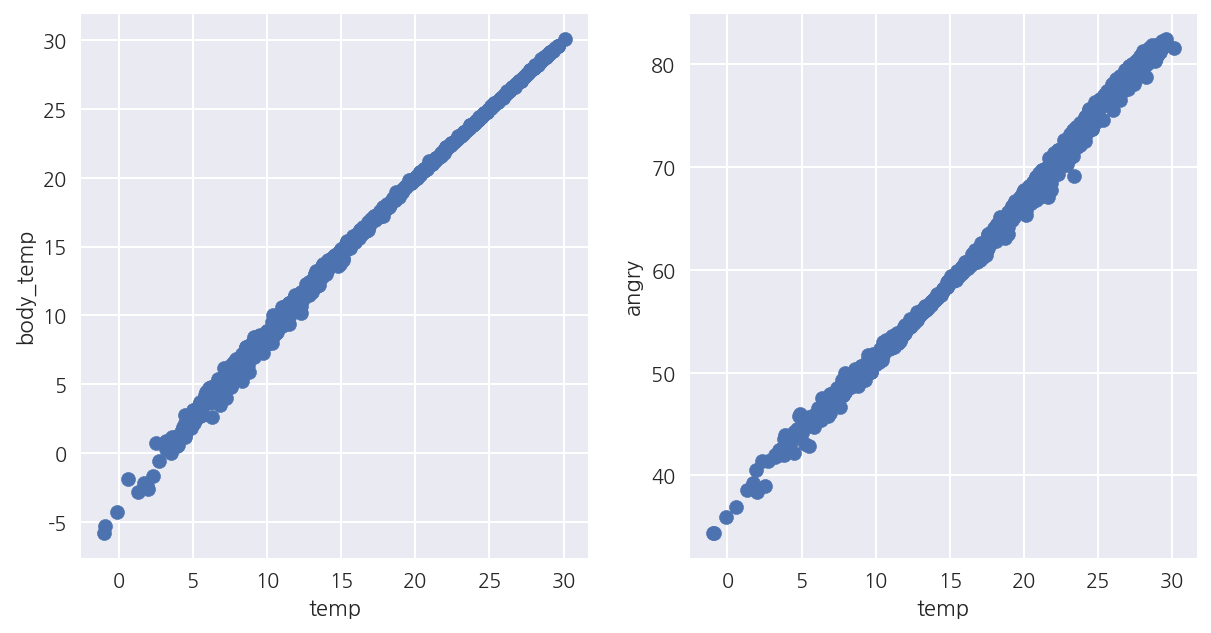

In [37]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(target_v2["temp"], target_v2["body_temp"])
plt.xlabel("temp")
plt.ylabel("body_temp")

plt.subplot(122)
plt.scatter(target_v2["temp"], target_v2["angry"])
plt.xlabel("temp")
plt.ylabel("angry")
plt.show()

##### VIF

In [38]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    target_v2[["temp", "body_temp", "angry"]].values, i) for i in range(3)]
vif["features"] = target_v2[["temp", "body_temp", "angry"]].columns
vif

,VIF Factor,features
0,2101.404235,temp
1,1346.719352,body_temp
2,104.519419,angry


##### PCA 분석

In [39]:
x = target_v2[["temp", "body_temp", "angry"]].values

pca = PCA(n_components = 2)
x_low = pca.fit_transform(x)

df_pca = pd.DataFrame(data = x_low, columns = ['pc1', 'pc2'])
df_pca.tail()

,pc1,pc2
833,-4.832391,-1.141121
834,-8.609103,0.058706
835,-3.565785,-0.174850
836,-2.333240,-0.492178
837,-7.130725,0.001296


In [40]:
target_v2["pc1"], target_v2["pc2"] = df_pca["pc1"], df_pca["pc2"]
target_v2.tail()

,date,smp_max,smp_min,smp_mean,temp,ws,prec,humid,angry,body_temp,tour,supply,pc1,pc2
833,2020-05-14,193.28,66.78,100.46,18.7,2.7,0.0,0.563,63.7,18.6,23327,62.70,-4.832391,-1.141121
834,2020-05-15,198.23,61.81,102.38,19.9,3.5,1.5,0.915,67.3,19.8,22135,64.91,-8.609103,0.058706
835,2020-05-16,220.91,88.50,121.19,17.6,2.0,0.2,0.966,63.5,17.4,23009,61.75,-3.565785,-0.174850
836,2020-05-17,207.75,65.78,116.82,17.1,2.2,0.0,0.916,62.4,17.0,24394,61.55,-2.333240,-0.492178
837,2020-05-18,113.31,66.86,98.98,19.2,3.1,0.4,0.921,66.2,19.1,24001,63.91,-7.130725,0.001296


#### PCA 성분 추가한 OLS 분석

In [41]:
formula_pca = ("scale(supply) ~ scale(smp_max) + scale(smp_min) + scale(smp_mean) +\
                            scale(ws) + scale(prec) + scale(humid) + \
                            scale(pc1) + scale(pc2) + scale(tour) + I(scale(temp)*scale(pc1))")

In [42]:
model2 = sm.OLS.from_formula(formula_pca, data=target_v2)
result2 = model2.fit()

In [43]:
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     242.8
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          3.29e-238
Time:                        16:42:56   Log-Likelihood:                -614.93
No. Observations:                 838   AIC:                             1252.
Df Residuals:                     827   BIC:                             1304.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

##### 냉방기, 난방기, 환절기를 나눠서 OLS분석
- 냉방기 : 5월 ~ 10월
- 난방기 : 11월 ~ 4월
- 환절기 : 추가 예정

#### 일별 전력 수요와 온도 그래프 시각화
- 온도와 전력 수요의 일별 변화 추이를 보기위해 RobustScaler 스케일 기법사용

In [58]:
scaler = RobustScaler()
data_scale = pd.DataFrame(scaler.fit_transform(target_v2[["temp", "supply"]]), columns = ["temp", "supply"])
data_scale.tail()

,temp,supply
833,0.258929,-0.727304
834,0.366071,-0.574732
835,0.160714,-0.792889
836,0.116071,-0.806697
837,0.303571,-0.643769


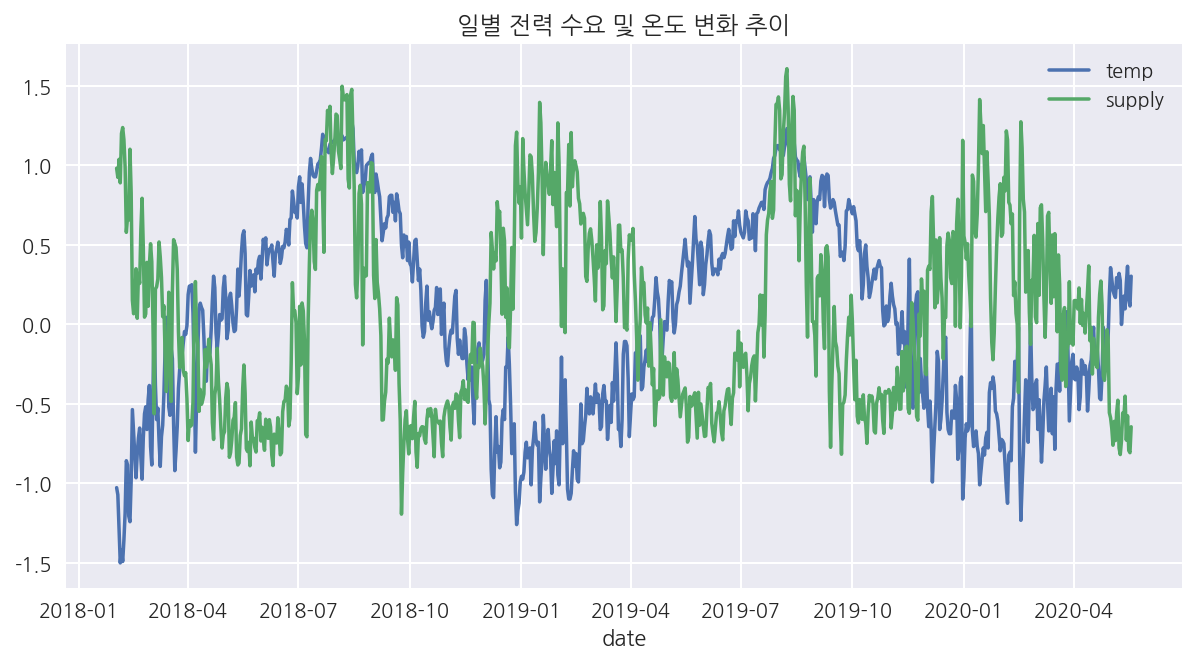

In [57]:
plt.figure(figsize=(10, 5), facecolor="1.")
plt.title("일별 전력 수요 및 온도 변화 추이")
plt.plot(target_v2["date"], data_scale["temp"], label = 'temp')
plt.plot(target_v2["date"], data_scale["supply"], label = 'supply')
plt.xlabel('date')
plt.legend()
plt.show()

In [44]:
# 냉방기 기간 : 5월 ~10월
summer = np.logical_and((pd.DatetimeIndex(target_v2["date"]).month >= 5),\
                        (pd.DatetimeIndex(target_v2["date"]).month < 11))
# 난방기 기간 : 11월 ~ 4월
winter = np.invert(summer)

##### 냉방기 OLS

In [45]:
target_summer = target_v2[summer]

In [46]:
model_summer = sm.OLS.from_formula(formula_pca, data=target_summer)

In [47]:
result_summer = model_summer.fit()

In [48]:
print(result_summer.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     523.4
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          2.12e-213
Time:                        16:42:57   Log-Likelihood:                -25.600
No. Observations:                 386   AIC:                             73.20
Df Residuals:                     375   BIC:                             116.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

##### 난방기 OLS

In [49]:
target_winter = target_v2[winter]

In [50]:
model_winter = sm.OLS.from_formula(formula_pca, data=target_winter)

In [51]:
result_winter = model_winter.fit()

In [52]:
print(result_winter.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     204.3
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          1.37e-158
Time:                        16:42:58   Log-Likelihood:                -250.69
No. Observations:                 452   AIC:                             523.4
Df Residuals:                     441   BIC:                             568.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### next step
#### 공휴일
- 2018년 1월부터 2020년 12월까지의 공휴일 정보
- 한국 법령 관공서의 공휴일에 관한 규정에 지정된 공휴일들만 취급
- 새해, 설날, 삼일절, 어린이날, 부처님오신날, 현충일, 광복절, 추석, 개천절, 한글날, 크리스마스

In [53]:
holiday = pd.read_csv("holidaylist.csv")

holiday["날짜"]= pd.to_datetime(holiday["날짜"])
holday_set = set(holiday["날짜"])

target_weekend = set(target_v2[target_v2["date"].dt.dayofweek % 7 >= 5]["date"])
holiday_date = list(holday_set.union(target_weekend))

In [54]:
target_v2["holiday"] = None
target_v2["holiday"] = target_v2[target_v2["date"].isin(holiday_date)]["holiday"].fillna(1)
target_v2["holiday"] = target_v2["holiday"].fillna(0)

In [55]:
target_v2.head(10)

,date,smp_max,smp_min,smp_mean,temp,ws,prec,humid,angry,body_temp,tour,supply,pc1,pc2,holiday
0,2018-02-01,150.65,116.84,132.71,4.3,3.9,0.0,0.601,43.7,1.9,33144,87.47,24.852682,1.077821,0.0
1,2018-02-02,163.86,116.84,134.19,3.8,4.3,0.0,0.553,43.5,1.0,31549,86.64,25.689008,1.710714,0.0
2,2018-02-03,164.07,116.85,131.39,1.3,6.9,0.0,0.673,38.6,-2.8,31348,88.28,32.338565,1.848699,1.0
3,2018-02-04,171.00,115.76,131.89,-1.0,7.0,0.1,0.720,34.4,-5.8,26980,86.14,37.978982,1.804526,1.0
4,2018-02-05,170.34,123.89,137.96,-0.1,6.5,0.2,0.712,35.9,-4.3,30188,90.63,35.708876,1.487031,0.0
5,2018-02-06,167.99,119.11,140.06,-0.9,6.2,0.2,0.730,34.4,-5.3,19613,91.18,37.676856,1.414179,0.0
6,2018-02-07,141.07,124.11,132.76,0.6,3.2,0.0,0.716,36.9,-1.9,28573,90.09,33.432518,0.215455,0.0
7,2018-02-08,147.42,116.84,132.91,2.5,2.4,0.2,0.784,39.0,0.7,25004,87.57,29.703239,-0.718555,0.0
8,2018-02-09,150.70,116.84,126.95,6.2,2.6,0.0,0.646,46.0,4.8,28622,81.63,20.824853,0.049121,0.0
9,2018-02-10,147.20,116.34,130.10,5.9,4.0,0.1,0.700,45.2,3.9,29624,83.00,22.003778,0.259791,1.0
